In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pytesseract
from PIL import Image
from urllib.request import urlopen
import re

In [3]:
CELL_SIZE = 8192
GRIDMAP_CORNERS = (-42, 61, -63, 38)


## Read scraped claims

Read all claims from our scraping output.

In [4]:
claims = pd.read_json("fetchclaims/ints.json")
claims.to_excel("claims.xlsx")

unlocated_mask = claims["cell_x"].isna()
print(f"{claims[unlocated_mask].shape[0]} claims without coordinates.")

## Find missing cell coordinates

First, extract from the claim image (this will take some time).

In [6]:
def get_coords_from_image(url, crop_coords=(0, 0, 300, 35), upscale=2, **kwargs):
    """Fetch coordinates from an image on specified url.

    Args:
        url (str): url from which to find image.
        crop_coords (tuple, optional): Crop the image to find the cell coordinates.
         Defaults to (0, 0, 200, 50).
        upscale: Scaling a small image up often helps Tesseract.
        **kwargs: Passed to pytesseract.image_to_string.

    Returns:
        tuple(int)/tuple(None): two cell coordinates, if found.
    """
    # Digit with optional minus (grp1), either a comma or point OR a space,
    # any number of optional spaces, another digit with minus (grp2).
    # OR, a separator of only a minus also works.
    cell_regex = r"(-?\d+)(?:(?:[,.]+|\s)\s?(-?\d+)|(-\d+))"

    image = Image.open(urlopen(url))
    image_small = image.crop(crop_coords)
    image_upscaled = image_small.resize(
        (image_small.width * upscale, image_small.height * upscale)
    )
    prediction = pytesseract.image_to_string(image_upscaled, **kwargs)
    try:
        matches = re.search(cell_regex, prediction).groups()
        # I couldn't figure out how to get the regex to return anything but three
        # groups, given I had to schemas for the second number. So, I just delete the
        # empty one for now.
        x, y = [match for match in matches if match]
        return int(x), int(y)
    except AttributeError:
        return None, None


image_mask = (unlocated_mask) & (~claims["image_url"].isna())
# The above function returns a tuple, which is finicky to get into two series.
img_coords = claims.loc[image_mask, "image_url"].apply(get_coords_from_image)
claims.loc[image_mask, "cell_x"] = img_coords.apply(lambda coords: coords[0])
claims.loc[image_mask, "cell_y"] = img_coords.apply(lambda coords: coords[1])

unlocated_mask = claims["cell_x"].isna()
print(f"{claims[unlocated_mask].shape[0]} claims without coordinates.")

19 claims without coordinates.


If that failed, try name-based detection.

In [7]:
# Name-based hints
name_hints = {
    "Ald Iuval Temple": (3, -42),
    "Thirr Valley #6 Farm #3": (0, -42),
    "Castle Narsis": (7, -51),
    "Ud Hleryn": (1, -44),
    "Firewatch": (17, 15),
    "Narsis, Waterfront": (7, -50),
    "Sadrathim": (8, -46),
    "Kemel-Ze": (22, -2),
    "Andothren": (0, -16),
}
for hint in name_hints:
    namemask = claims["title"].str.contains(hint, case=False)
    claims.loc[namemask, ["cell_x", "cell_y"]] = name_hints[hint]

unlocated_mask = claims["cell_x"].isna()
print(f"{claims[unlocated_mask].shape[0]} claims without coordinates.")

8 claims without coordinates.


Finally, fix known one-off errors.

In [8]:
url_hints = {
    # OW #5 Ancestral Tomb #1 is not getting picked up by pytesseract
    "https://www.tamriel-rebuilt.org/claims/othreleth-woods-5-ancestral-tomb-1": (
        -5,
        -31,
    ),
    # Olanar ints are not picked up by pytesseract
    "https://www.tamriel-rebuilt.org/claims/olanar-shaav-grotto": (55, 17),
    "https://www.tamriel-rebuilt.org/claims/olanar-vadridan": (54, 15),
    # TV06 uses handwriting for cell numbers
    "https://www.tamriel-rebuilt.org/claims/thirr-valley-6-redoran-ruin": (2, -46),
    "https://www.tamriel-rebuilt.org/claims/thirr-valley-6-ranch-1": (3, -46),
    "https://www.tamriel-rebuilt.org/claims/thirr-valley-6-grotto-2": (3, -45),
    # TV04 claims have no cell numbers
    "https://www.tamriel-rebuilt.org/claims/thirr-valley-4-ancestral-tomb-2": (8, -45),
    # Weird archaeology thing
    "https://www.tamriel-rebuilt.org/claims/archaeology-ancestral-tomb": (-18, -7),
}
for hint in url_hints:
    urlmask = claims["url"] == hint
    claims.loc[urlmask, ["cell_x", "cell_y"]] = url_hints[hint]

unlocated_mask = claims["cell_x"].isna()
print(f"{claims[unlocated_mask].shape[0]} claims without coordinates.")

0 claims without coordinates.


Convert to map coordinates, make colors to plot the claims by.

In [ ]:
# Coordinates in units, not cells
located_claims = claims[~claims["cell_x"].isna()].copy()
print(f"Found {located_claims.shape[0]} claims with known cell coordinates")
located_claims["cell_x_map"] = located_claims["cell_x"] * CELL_SIZE + CELL_SIZE / 2
located_claims["cell_y_map"] = located_claims["cell_y"] * CELL_SIZE + CELL_SIZE / 2

# Colors for the plot
# TODO: make the stage thing into an ordered category
unique_stages = located_claims["stage"].unique()
colors = {stage: f"C{i[0]}" for i, stage in np.ndenumerate(unique_stages)}
located_claims["color"] = located_claims["stage"].map(lambda x: colors[x])
located_claims.sort_values(by="cell_y", ascending=False).head(10)


Found 152 claims with known cell coordinates


,title,stage,description,cell_x,cell_y,last_update,url,image_url,cell_x_map,cell_y_map,color
164,[Olanar] Tel Inan,In Development,The abandoned former home of an extremely recl...,55.0,15.0,2022-06-01 22:05,https://www.tamriel-rebuilt.org/claims/olanar-...,https://www.tamriel-rebuilt.org/sites/default/...,454656.0,126976.0,C0
85,TR Firemoth: Ruined Dock Tower,Under Review,Fort Firemoths Dock tower Formerly the seat ...,-8.0,-10.0,2022-11-30 11:37,https://www.tamriel-rebuilt.org/claims/tr-fire...,https://www.tamriel-rebuilt.org/sites/default/...,-61440.0,-77824.0,C3
88,TR Firemoth: Ruined Keep Tower,Under Review,The Keep Tower of Fort Firemoth Formerly the...,-8.0,-11.0,2022-11-30 11:37,https://www.tamriel-rebuilt.org/claims/tr-fire...,https://www.tamriel-rebuilt.org/sites/default/...,-61440.0,-86016.0,C3
7,TR Firemoth: Mine,Under Review,"Fort Firemoths Mine One exit, the other is i...",-9.0,-11.0,2022-12-09 22:33,https://www.tamriel-rebuilt.org/claims/tr-fire...,https://www.tamriel-rebuilt.org/sites/default/...,-69632.0,-86016.0,C3
87,Aanthirin Expansion Cave #1,Pending Review,Cave near Old Ebonheart A small cave at the ...,8.0,-20.0,2022-12-01 00:55,https://www.tamriel-rebuilt.org/claims/aanthir...,https://www.tamriel-rebuilt.org/sites/default/...,69632.0,-159744.0,C1
0,Aanthirin Expansion Velothi Tower #2,In Development,Velothi Tower on the road from Old Ebonheart ...,8.0,-21.0,2022-12-11 02:22,https://www.tamriel-rebuilt.org/claims/aanthir...,https://www.tamriel-rebuilt.org/sites/default/...,69632.0,-167936.0,C0
72,Aanthirin Expansion Old Mournhold Ruin #1,In Development,Old Mournhold on top of a hill between Dondril...,10.0,-23.0,2022-11-24 03:34,https://www.tamriel-rebuilt.org/claims/aanthir...,https://www.tamriel-rebuilt.org/sites/default/...,86016.0,-184320.0,C0
73,Aanthirin Expansion Cave #2,Pending Review,Grotto near Hadrumnibibi A grotto near the ...,6.0,-24.0,2022-11-25 23:50,https://www.tamriel-rebuilt.org/claims/aanthir...,https://www.tamriel-rebuilt.org/sites/default/...,53248.0,-192512.0,C1
75,Aanthirin Expansion Velothi Tower #1,Pending Review,Velothi Tower near Roa Dyr Tower haunted by ...,10.0,-26.0,2022-11-26 03:19,https://www.tamriel-rebuilt.org/claims/aanthir...,https://www.tamriel-rebuilt.org/sites/default/...,86016.0,-208896.0,C1
82,Aanthirin Expansion Cave #3,In Development,Cave near Tur Julan at the mouth of a dead riv...,0.0,-26.0,2022-11-27 23:00,https://www.tamriel-rebuilt.org/claims/aanthir...,https://www.tamriel-rebuilt.org/sites/default/...,4096.0,-208896.0,C0


Plot the thing.

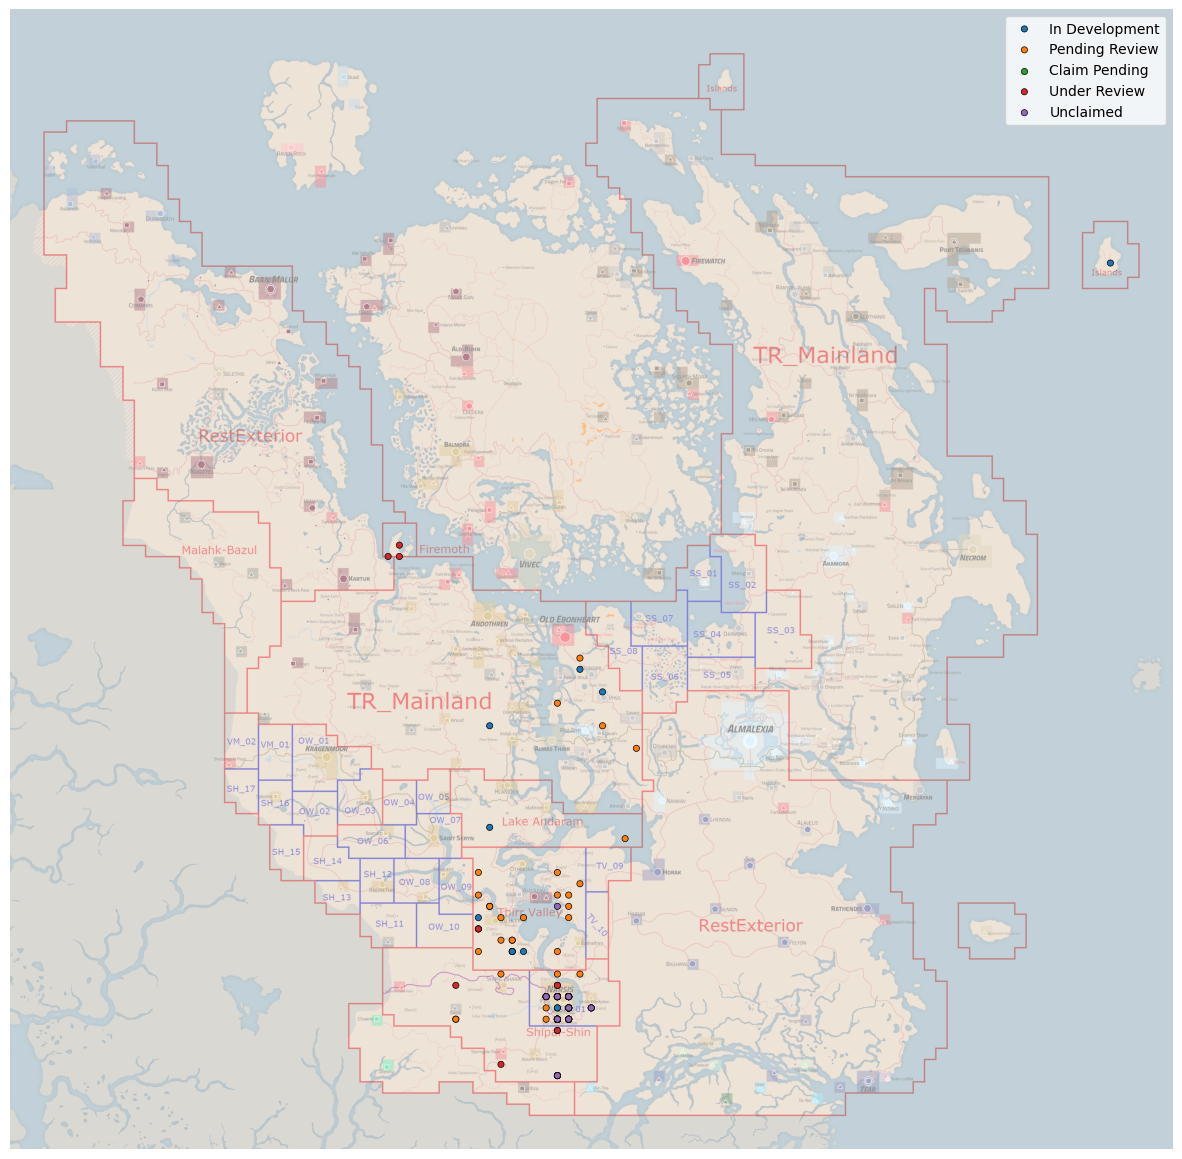

In [83]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the map to the background
mapfile = plt.imread("Tamriel Rebuilt Province Map_2022-11-25.png")
ax.imshow(mapfile, extent=[n * CELL_SIZE for n in GRIDMAP_CORNERS], alpha=0.5)

# Draw claims
for stage in located_claims["stage"].unique():
    ax.scatter(
        data=located_claims[located_claims["stage"] == stage],
        x="cell_x_map",
        y="cell_y_map",
        color="color",
        s=20,
        edgecolor="black",
        linewidth=0.5,
        label=stage,
    )

ax.axis("off")
ax.legend()
